In [3]:
# !pip install transformers[torch]
# !pip install -U datasets
# !pip install -U transformers
# !pip install -U accelerate
# !pip freeze | grep accelerate
# #Must use GPU

Text(0.5, 1.0, 'Emotion Sentiment Distribution')

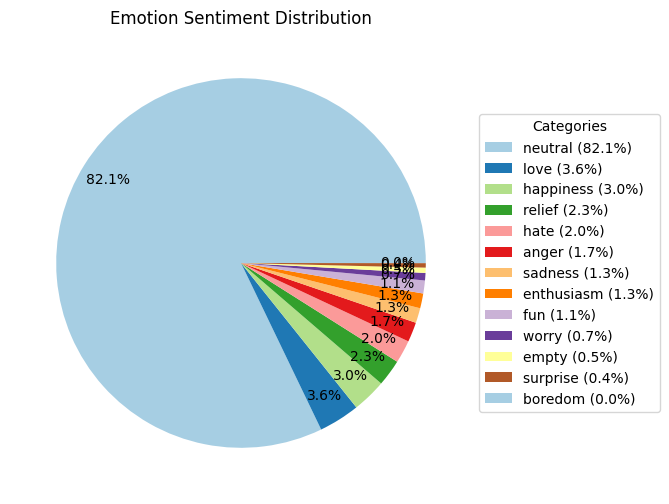

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import os.path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



# Load the emotion analysis dataset
# dataset_file_name = os.path.join('drive','MyDrive','Colab Notebooks',"emotion_sentiment_dataset.csv")
# dataset_file_name = os.path.join("emotion_sentiment_dataset.csv")\

dataset = pd.read_csv("/Users/shaicahana/Documents/AI_DL/colab/AI-DL/project-3/emotion_sentiment_dataset.csv")
dataset = dataset.head(10000)

###===== Part 1.1 =======
# Draw a pie plot using matplotlib of all the possible emotions
values, counts = np.unique(dataset['Emotion'][:], return_counts=True)
sorted_pairs = sorted(zip(counts, values), reverse=True)  # legend by frequency
sizes_sorted, labels_sorted = zip(*sorted_pairs)

# Calculate percentages
total = sum(sizes_sorted)
percentages = [count/total * 100 for count in sizes_sorted]

# Create labels with percentages for legend
labels_with_pct = [f'{label} ({pct:.1f}%)' for label, pct in zip(labels_sorted, percentages)]

colors = sns.color_palette("Paired", len(counts))  # no repeating colors
plt.figure(figsize=(16, 6))  # Make the plot wider

# Add autopct parameter to display percentages on the pie chart
plt.pie(sizes_sorted, 
        colors=colors, 
        autopct='%1.1f%%',  # Display percentages on pie slices
        pctdistance=0.85)   # Adjust distance of percentage labels from center

plt.legend(labels_with_pct,  # Use new labels with percentages
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))  # place legend outside

plt.title('Emotion Sentiment Distribution')
###=====

In [5]:
dataset.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


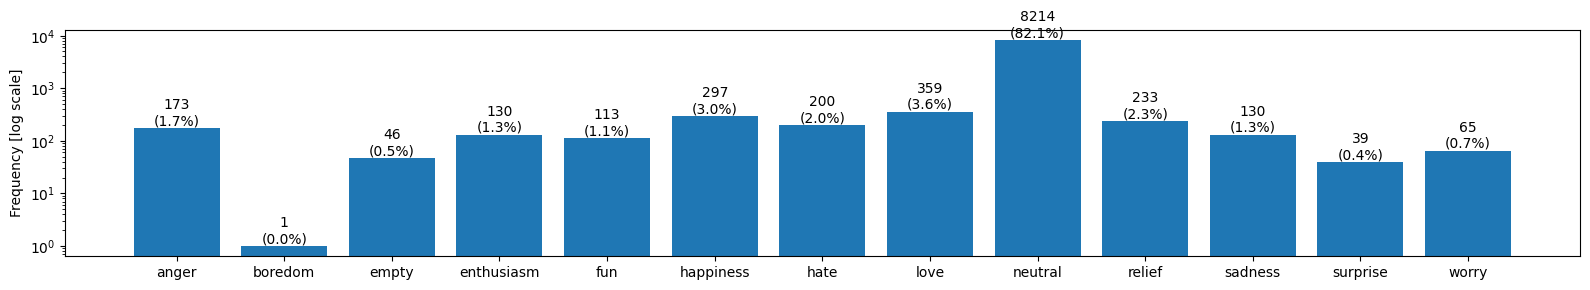

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate percentages
total = sum(counts)
percentages = [(count/total) * 100 for count in counts]

plt.figure(figsize=(16, 3))  # Make the plot wider

# Create bars
bars = plt.bar(values, counts)
plt.yscale('log')
plt.ylabel('Frequency [log scale]')

# Add percentage labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        percentage = (height/total) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({percentage:.1f}%)',
                ha='center', va='bottom')

add_labels(bars)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [7]:
# Map emotions to 'neutral' and 'non-neutral'
dataset['Emotion'] = dataset['Emotion'].apply(lambda x: 0 if x == 'neutral' else 1)


In [8]:
# plt.hist(dataset['Emotion'])



In [9]:
import pandas as pd
from sklearn.utils import resample
from collections import Counter

def balance_dataset(dataset, method='undersample'):
    """
    Balance a binary classification dataset using various methods.
    
    Parameters:
    dataset: pandas DataFrame with 'Emotion' column (0 for neutral, 1 for non-neutral)
    method: str, options: 'undersample', 'oversample', 'smote'
    
    Returns:
    Balanced pandas DataFrame
    """
    # Get current class distribution
    class_counts = Counter(dataset['Emotion'])
    print(f"Original class distribution: {class_counts}")
    
    if method == 'undersample':
        # Separate majority and minority classes
        majority = dataset[dataset['Emotion'] == 0]
        minority = dataset[dataset['Emotion'] == 1]
        
        # Undersample majority class
        majority_downsampled = resample(
            majority,
            replace=False,
            n_samples=len(minority),
            random_state=42
        )
        
        # Combine minority class with downsampled majority class
        balanced_df = pd.concat([majority_downsampled, minority])
        
    elif method == 'oversample':
        # Separate majority and minority classes
        majority = dataset[dataset['Emotion'] == 0]
        minority = dataset[dataset['Emotion'] == 1]
        
        # Oversample minority class
        minority_upsampled = resample(
            minority,
            replace=True,
            n_samples=len(majority),
            random_state=42
        )
        
        # Combine majority class with upsampled minority class
        balanced_df = pd.concat([majority, minority_upsampled])
        

    print(f"Balanced class distribution: {Counter(balanced_df['Emotion'])}")
    return balanced_df.sample(frac=1).reset_index(drop=True)  # Shuffle and reset index


dataset = balance_dataset(dataset, method='oversample')


Original class distribution: Counter({0: 8214, 1: 1786})
Balanced class distribution: Counter({0: 8214, 1: 8214})


In [10]:
import random
import pandas as pd
random.seed(42)
dataset['Type'] = ['Train' if random.random() < 0.8 else 'Test' for _ in dataset['Emotion']]

# Split dataset into train and test sets
train_texts = dataset[dataset['Type'] == "Train" ]['text']
train_labels = dataset[dataset['Type'] == "Train" ]['Emotion']

test_texts = dataset[dataset['Type'] == "Test" ]['text']
test_labels = dataset[dataset['Type'] == "Test" ]['Emotion']

In [11]:
import numpy as np
percent_of_minority_train = np.mean(train_labels)*100
percent_of_minority_test = np.mean(test_labels)*100
print(f" {percent_of_minority_train:.2f}% in training set" )
print(f" {percent_of_minority_test:.2f}% in testing set" )

 49.93% in training set
 50.28% in testing set


In [12]:
# Prepare the dataset for the transformer
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': train_texts,
    'label': train_labels
}))
test_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': test_texts,
    'label': test_labels
}))

# Load pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Function to tokenize the dataset
def tokenize_data(example):
    return tokenizer(example['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13156 [00:00<?, ? examples/s]

Map:   0%|          | 0/3272 [00:00<?, ? examples/s]

In [13]:
# # Define training arguments
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=5,
#     logging_dir='./logs',
#     do_eval=True,
#     evaluation_strategy="epoch"
# )

# # Initialize Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset
# )

# # Train the model
# trainer.train()

# # Evaluate the model
# results = trainer.evaluate()
# print(results)

In [14]:
import wandb
from transformers.integrations import WandbCallback
# Initialize wandb
wandb.init(
    project="emotion-classification",
    name="distilbert-emotion-balanced",
    config={
        "epochs": 5,
        "batch_size": 16,
        "learning_rate": 5e-5,
        "model": "distilbert-base-uncased",
    }
)


In [15]:
# Add to imports at the top


class CustomWandbCallback(WandbCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and state.is_world_process_zero:
            # Log eval metrics
            metrics = {k.replace("eval_", ""): v for k, v in metrics.items()}
            wandb.log(
                {f"eval/{k}": v for k, v in metrics.items()},
                step=state.global_step
            )
            
            # Calculate and log precision/recall if predictions are available
            if hasattr(self, "last_predictions") and hasattr(self, "last_labels"):
                precision, recall = compute_precision_recall(
                    self.last_predictions, 
                    self.last_labels
                )
                wandb.log({
                    "eval/precision": precision,
                    "eval/recall": recall
                }, step=state.global_step)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    logging_dir='./logs',
    do_eval=True,
    evaluation_strategy="epoch",
    # Add wandb logging parameters
    report_to="wandb",           # Enable wandb logging
    logging_steps=100,           # Log every 100 steps
    save_strategy="epoch",       # Save model every epoch
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Use eval loss to determine best model
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[CustomWandbCallback]  # Add the custom wandb callback
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

# Calculate final metrics
train_output = trainer.predict(train_dataset)
train_predictions = train_output.predictions.argmax(-1)
train_references = train_output.label_ids

test_output = trainer.predict(test_dataset)
test_predictions = test_output.predictions.argmax(-1)
test_references = test_output.label_ids


/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


  0%|          | 0/4115 [00:00<?, ?it/s]

{'loss': 0.5352, 'grad_norm': 1.8519574403762817, 'learning_rate': 4.8784933171324426e-05, 'epoch': 0.12}
{'loss': 0.2151, 'grad_norm': 1.3376407623291016, 'learning_rate': 4.756986634264885e-05, 'epoch': 0.24}
{'loss': 0.1537, 'grad_norm': 2.526611566543579, 'learning_rate': 4.6354799513973266e-05, 'epoch': 0.36}
{'loss': 0.0924, 'grad_norm': 0.15747541189193726, 'learning_rate': 4.513973268529769e-05, 'epoch': 0.49}
{'loss': 0.0658, 'grad_norm': 1.3590359687805176, 'learning_rate': 4.392466585662211e-05, 'epoch': 0.61}
{'loss': 0.0389, 'grad_norm': 0.018513111397624016, 'learning_rate': 4.2709599027946537e-05, 'epoch': 0.73}
{'loss': 0.029, 'grad_norm': 0.037143975496292114, 'learning_rate': 4.149453219927097e-05, 'epoch': 0.85}
{'loss': 0.0622, 'grad_norm': 75.90516662597656, 'learning_rate': 4.027946537059539e-05, 'epoch': 0.97}


  0%|          | 0/205 [00:00<?, ?it/s]

{'eval_loss': 0.05370212346315384, 'eval_runtime': 72.7897, 'eval_samples_per_second': 44.951, 'eval_steps_per_second': 2.816, 'epoch': 1.0}
{'loss': 0.0336, 'grad_norm': 0.03526027128100395, 'learning_rate': 3.906439854191981e-05, 'epoch': 1.09}
{'loss': 0.0179, 'grad_norm': 0.017904743552207947, 'learning_rate': 3.784933171324423e-05, 'epoch': 1.22}
{'loss': 0.0039, 'grad_norm': 0.008198912255465984, 'learning_rate': 3.6634264884568654e-05, 'epoch': 1.34}
{'loss': 0.0117, 'grad_norm': 0.01218415703624487, 'learning_rate': 3.541919805589308e-05, 'epoch': 1.46}
{'loss': 0.0132, 'grad_norm': 0.06212763860821724, 'learning_rate': 3.42041312272175e-05, 'epoch': 1.58}
{'loss': 0.0089, 'grad_norm': 0.015258895233273506, 'learning_rate': 3.298906439854192e-05, 'epoch': 1.7}
{'loss': 0.0028, 'grad_norm': 0.003376236418262124, 'learning_rate': 3.177399756986634e-05, 'epoch': 1.82}
{'loss': 0.0215, 'grad_norm': 0.1686314046382904, 'learning_rate': 3.0558930741190765e-05, 'epoch': 1.94}


  0%|          | 0/205 [00:00<?, ?it/s]

{'eval_loss': 0.03290260583162308, 'eval_runtime': 71.7872, 'eval_samples_per_second': 45.579, 'eval_steps_per_second': 2.856, 'epoch': 2.0}
{'loss': 0.002, 'grad_norm': 0.00521476473659277, 'learning_rate': 2.934386391251519e-05, 'epoch': 2.07}
{'loss': 0.0108, 'grad_norm': 0.003575455630198121, 'learning_rate': 2.8128797083839615e-05, 'epoch': 2.19}
{'loss': 0.005, 'grad_norm': 25.50472068786621, 'learning_rate': 2.691373025516404e-05, 'epoch': 2.31}
{'loss': 0.0025, 'grad_norm': 0.024773653596639633, 'learning_rate': 2.5698663426488455e-05, 'epoch': 2.43}
{'loss': 0.0049, 'grad_norm': 0.005204792134463787, 'learning_rate': 2.448359659781288e-05, 'epoch': 2.55}
{'loss': 0.0007, 'grad_norm': 0.0027806535363197327, 'learning_rate': 2.3268529769137302e-05, 'epoch': 2.67}
{'loss': 0.0067, 'grad_norm': 0.002233300358057022, 'learning_rate': 2.205346294046173e-05, 'epoch': 2.79}
{'loss': 0.0011, 'grad_norm': 0.002145990263670683, 'learning_rate': 2.083839611178615e-05, 'epoch': 2.92}


  0%|          | 0/205 [00:00<?, ?it/s]

{'eval_loss': 0.02636265940964222, 'eval_runtime': 71.3264, 'eval_samples_per_second': 45.874, 'eval_steps_per_second': 2.874, 'epoch': 3.0}
{'loss': 0.0065, 'grad_norm': 0.002992988098412752, 'learning_rate': 1.9623329283110573e-05, 'epoch': 3.04}
{'loss': 0.0001, 'grad_norm': 0.11306832730770111, 'learning_rate': 1.8408262454434993e-05, 'epoch': 3.16}
{'loss': 0.0001, 'grad_norm': 0.0031500589102506638, 'learning_rate': 1.7193195625759416e-05, 'epoch': 3.28}
{'loss': 0.0002, 'grad_norm': 0.0011045006103813648, 'learning_rate': 1.597812879708384e-05, 'epoch': 3.4}
{'loss': 0.0001, 'grad_norm': 0.001754596596583724, 'learning_rate': 1.4763061968408262e-05, 'epoch': 3.52}
{'loss': 0.0, 'grad_norm': 0.001266924082301557, 'learning_rate': 1.3547995139732685e-05, 'epoch': 3.65}
{'loss': 0.0043, 'grad_norm': 0.0009294290211983025, 'learning_rate': 1.2332928311057109e-05, 'epoch': 3.77}
{'loss': 0.0093, 'grad_norm': 0.2923639714717865, 'learning_rate': 1.1117861482381532e-05, 'epoch': 3.89}


  0%|          | 0/205 [00:00<?, ?it/s]

{'eval_loss': 0.02363317832350731, 'eval_runtime': 72.9422, 'eval_samples_per_second': 44.857, 'eval_steps_per_second': 2.81, 'epoch': 4.0}
{'loss': 0.0006, 'grad_norm': 0.0013926182873547077, 'learning_rate': 9.902794653705954e-06, 'epoch': 4.01}
{'loss': 0.0024, 'grad_norm': 0.0010624711867421865, 'learning_rate': 8.687727825030377e-06, 'epoch': 4.13}
{'loss': 0.0002, 'grad_norm': 0.0008499336545355618, 'learning_rate': 7.472660996354799e-06, 'epoch': 4.25}
{'loss': 0.0, 'grad_norm': 0.002838584128767252, 'learning_rate': 6.257594167679224e-06, 'epoch': 4.37}
{'loss': 0.0, 'grad_norm': 0.0004723156744148582, 'learning_rate': 5.042527339003645e-06, 'epoch': 4.5}
{'loss': 0.0, 'grad_norm': 0.0012810828629881144, 'learning_rate': 3.827460510328068e-06, 'epoch': 4.62}
{'loss': 0.0001, 'grad_norm': 0.0008207540959119797, 'learning_rate': 2.612393681652491e-06, 'epoch': 4.74}
{'loss': 0.0001, 'grad_norm': 0.0007901282515376806, 'learning_rate': 1.3973268529769137e-06, 'epoch': 4.86}
{'loss

  0%|          | 0/205 [00:00<?, ?it/s]

{'eval_loss': 0.02514687366783619, 'eval_runtime': 72.6991, 'eval_samples_per_second': 45.007, 'eval_steps_per_second': 2.82, 'epoch': 5.0}
{'train_runtime': 4966.5882, 'train_samples_per_second': 13.245, 'train_steps_per_second': 0.829, 'train_loss': 0.03314003297013914, 'epoch': 5.0}


  0%|          | 0/205 [00:00<?, ?it/s]

{'eval_loss': 0.02363317832350731, 'eval_runtime': 75.303, 'eval_samples_per_second': 43.451, 'eval_steps_per_second': 2.722, 'epoch': 5.0}


  0%|          | 0/823 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 4115 that is less than the current step 4119. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


  0%|          | 0/205 [00:00<?, ?it/s]

In [16]:

###===== Part 1.3 =======
## Write a code that calculates the precision and recall on the training and testing dataset
# Function to calculate precision and recall
def calc_confusion_matrix(predictions, references):
        # Initialize counters
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0
    
    # Count TP, FP, FN
    for pred, ref in zip(predictions, references):
        if pred == 1 and ref == 1:  # True Positive
            true_positives += 1
        elif pred == 1 and ref == 0:  # False Positive
            false_positives += 1
        elif pred == 0 and ref == 1:  # False Negative
            false_negatives += 1
        elif pred == 0 and ref == 0:  # False Negative
            true_negatives += 1
        
        confusion_matrix = {
        'True Positives': true_positives,
        'False Positives': false_positives,
        'True Negatives': true_negatives,
        'False Negatives': false_negatives
    }
    return confusion_matrix

def compute_precision_recall(predictions, references):
    confusion_matrix = calc_confusion_matrix(predictions, references)
    true_positives = confusion_matrix['True Positives']
    false_positives = confusion_matrix['False Positives']
    false_negatives = confusion_matrix['False Negatives']

    # Calculate precision and recall
    # Handle division by zero cases
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall



# Predict outputs for the training dataset
train_output = trainer.predict(train_dataset)
train_predictions = train_output.predictions.argmax(-1)
train_references = train_output.label_ids

# Predict outputs for the testing dataset
test_output = trainer.predict(test_dataset)
test_predictions = test_output.predictions.argmax(-1)
test_references = test_output.label_ids


  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

In [17]:


# Compute precision and recall for the training dataset
train_precision, train_recall= compute_precision_recall(train_predictions, train_references)
print(f"Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}")

# Compute precision and recall for the testing dataset
test_precision, test_recall = compute_precision_recall(test_predictions, test_references)
print(f"Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}")




Training Precision: 1.0000, Training Recall: 1.0000
Testing Precision: 0.9988, Testing Recall: 0.9964


In [18]:
confusion_matrix_train = calc_confusion_matrix(train_predictions, train_references)
confusion_matrix_test = calc_confusion_matrix(test_predictions, test_references)

print(confusion_matrix_train)
print(confusion_matrix_test)

{'True Positives': 6569, 'False Positives': 0, 'True Negatives': 6587, 'False Negatives': 0}
{'True Positives': 1639, 'False Positives': 2, 'True Negatives': 1625, 'False Negatives': 6}


In [19]:

# Log final metrics to wandb
train_precision, train_recall = compute_precision_recall(train_predictions, train_references)
test_precision, test_recall = compute_precision_recall(test_predictions, test_references)

wandb.log({
    "final/train_precision": train_precision,
    "final/train_recall": train_recall,
    "final/test_precision": test_precision,
    "final/test_recall": test_recall
})

# Print metrics
print(f"Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}")
print(f"Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}")

# Close wandb run
wandb.finish()

Training Precision: 1.0000, Training Recall: 1.0000
Testing Precision: 0.9988, Testing Recall: 0.9964


eval/epoch,▁▃▅▆█
eval/loss,███▃▃▃▂▂▂▁▁▁▁▁▁▁▁
eval/runtime,▄▄▄▂▂▂▁▁▁▄▄▄▃▃▃██
eval/samples_per_second,▅▅▅▇▇▇███▅▅▅▅▅▅▁▁
eval/steps_per_second,▅▅▅▇▇▇███▅▅▅▆▆▆▁▁
final/test_precision,▁
final/test_recall,▁
final/train_precision,▁
final/train_recall,▁
test/loss,▁▁██▁▁██
test/runtime,██▁▁██▁▁
